## Miniproject 2: MovieLens Visualization



### Download data

In [1]:
import requests

url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import numpy.linalg as la
from surprise import Reader, SVD, Dataset, accuracy


In [2]:
data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Basic Visualizations

Do pandas wizardry to select certain movies and ratings.

In [29]:
top10popularmovies = data["Movie ID"].value_counts()[:10]
top10popularmovies_indices = np.array(top10popularmovies.keys()) - 1
popular_data = data.loc[data["Movie ID"].isin(top10popularmovies.keys())]
top10ratedmovies = data.groupby('Movie ID')['Rating'].mean().sort_values(ascending=False)[:10]
top10ratedmovies_indices = np.array(top10ratedmovies.keys()) - 1
highrated_data = data.loc[data["Movie ID"].isin(top10ratedmovies.keys())]


horror_movies = movies.loc[movies["Horror"] == 1]
crime_movies = movies.loc[movies["Crime"] == 1]
western_movies = movies.loc[movies["Western"] == 1]

horror_data = data.loc[data["Movie ID"].isin(horror_movies["Movie ID"])]
crime_data = data.loc[data["Movie ID"].isin(crime_movies["Movie ID"])]
western_data = data.loc[data["Movie ID"].isin(western_movies["Movie ID"])]

Create histograms

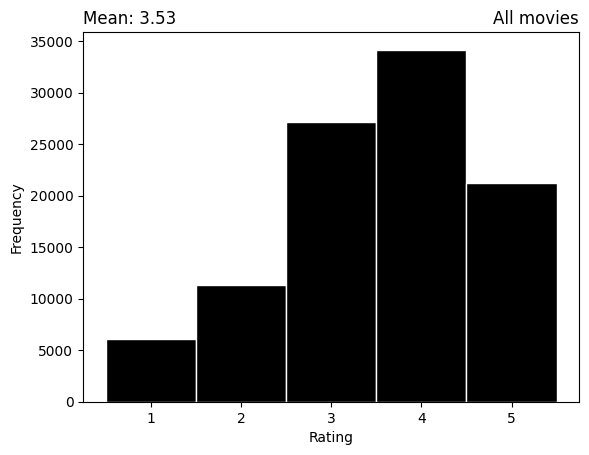

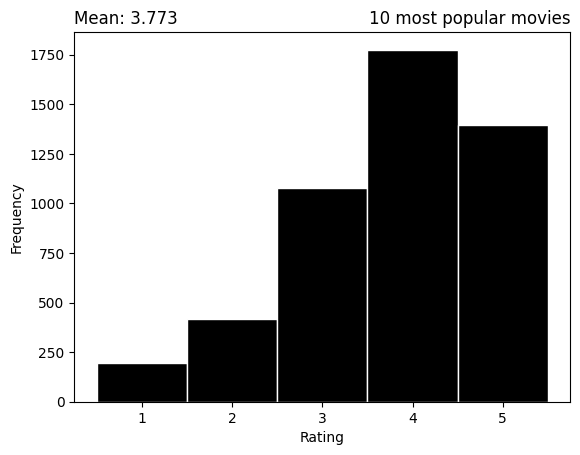

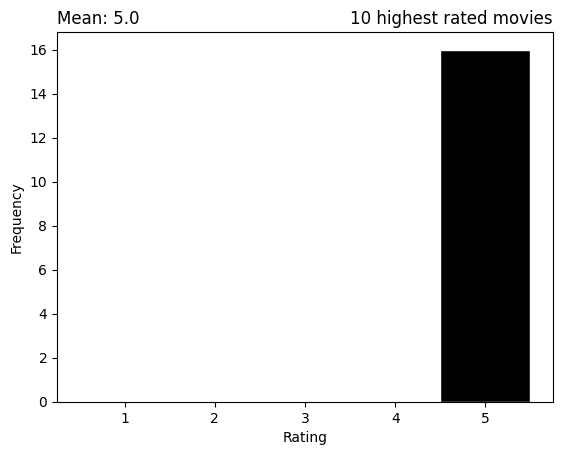

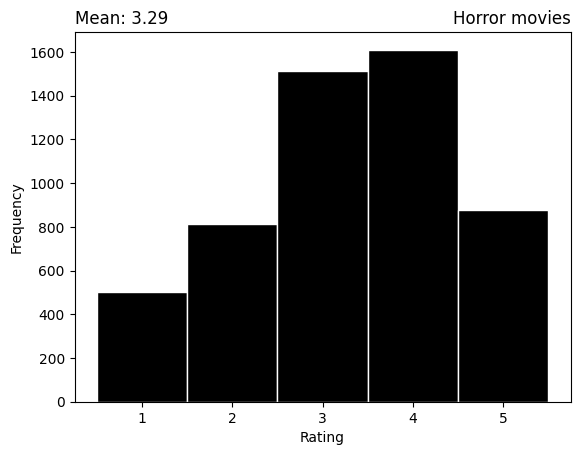

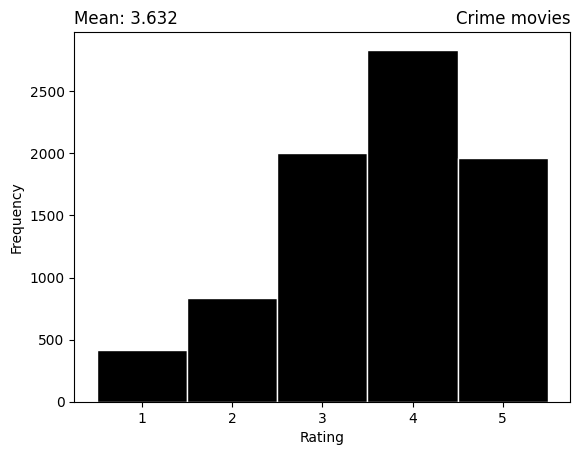

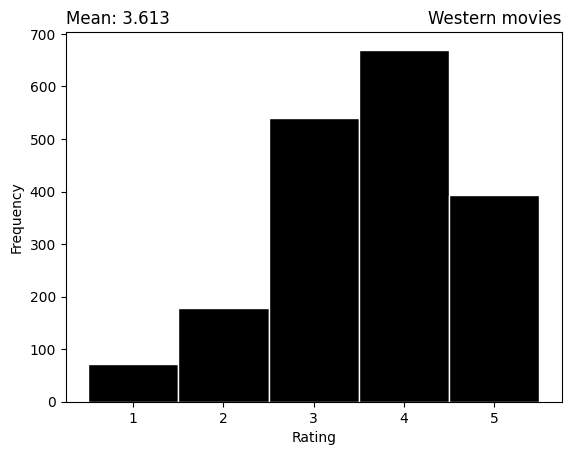

In [129]:
fig, ax = plt.subplots()
ax.hist(data["Rating"], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color="black", ec="white")
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
ax.set_title("All movies", loc="right")
ax.set_title(f"Mean: {round(np.mean(data['Rating']), 3)}", loc="left")
plt.savefig("./rating_hist.png", dpi=600, bbox_inches="tight")

fig, ax = plt.subplots()
ax.hist(popular_data["Rating"], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color="black", ec="white")
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
ax.set_title("10 most popular movies", loc="right")
ax.set_title(f"Mean: {round(np.mean(popular_data['Rating']), 3)}", loc="left")
plt.savefig("./popular_rating_hist.png", dpi=600, bbox_inches="tight")

fig, ax = plt.subplots()
ax.hist(highrated_data["Rating"], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color="black", ec="white")
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
ax.set_title("10 highest rated movies", loc="right")
ax.set_title(f"Mean: {np.mean(highrated_data['Rating'])}", loc="left")
plt.savefig("./high_rating_hist.png", dpi=600, bbox_inches="tight")

fig, ax = plt.subplots()
ax.hist(horror_data["Rating"], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color="black", ec="white")
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
ax.set_title("Horror movies", loc="right")
ax.set_title(f"Mean: {round(np.mean(horror_data['Rating']), 3)}", loc="left")
plt.savefig("./horror_rating_hist.png", dpi=600, bbox_inches="tight")

fig, ax = plt.subplots()
ax.hist(crime_data["Rating"], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color="black", ec="white")
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
ax.set_title("Crime movies", loc="right")
ax.set_title(f"Mean: {round(np.mean(crime_data['Rating']), 3)}", loc="left")
plt.savefig("./crime_rating_hist.png", dpi=600, bbox_inches="tight")

fig, ax = plt.subplots()
ax.hist(western_data["Rating"], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color="black", ec="white")
ax.set_xlabel("Rating")
ax.set_ylabel("Frequency")
ax.set_title("Western movies", loc="right")
ax.set_title(f"Mean: {round(np.mean(western_data['Rating']), 3)}", loc="left")
plt.savefig("./western_rating_hist.png", dpi=600, bbox_inches="tight")

## Matrix Factorization Visualizations

### Homework 5: Implementation

In [105]:
def grad_U(Ui, Yij, Vj, reg, eta):
    return eta * (reg * Ui - Vj * (Yij - np.matmul(Vj, Ui)))

def grad_V(Vj, Yij, Ui, reg, eta):
    return eta * (reg * Vj - Ui * (Yij - np.matmul(Vj, Ui)))

def get_err(U, V, Y, reg=0.0):
    errors = []
    for i, j, Y_ij in Y:
        errors.append(0.5 * (Y_ij - np.matmul(V[j-1], U[i-1]))**2)
    return np.mean(errors)


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    # Initialize entries of U and V and losses
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    loss_vals = [get_err(U, V, Y)]

    for iter in range(max_epochs):
        # Shuffle matrix
        Y = Y[np.random.permutation(len(Y))]
        for datum in Y:
            U[datum[0] - 1] -= grad_U(U[datum[0] - 1], datum[2], V[datum[1] - 1], reg, eta)
            V[datum[1] - 1] -= grad_V(V[datum[1] - 1], datum[2], U[datum[0] - 1], reg, eta)
        loss_vals.append(get_err(U, V, Y))
        if iter > 0 and (loss_vals[iter] - loss_vals[iter + 1]) / (loss_vals[0] - loss_vals[1]) <= eps:
        break
    return U, V, get_err(U, V, Y)

Train models

In [90]:
Y_train = np.array(train).astype(int)
Y_test = np.array(test).astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.0
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
U,V, err = train_model(M, N, K, eta, reg, Y_train)
E_in = err
E_out = get_err(U, V, Y_test)
print(f"E_in: {E_in}")
print(f"E_out: {E_out}")

Factorizing with  943  users,  1682  movies.
E_in: 0.255122274263613
E_out: 0.6775757631616117


Find A and project

In [91]:
A = np.linalg.svd(V.transpose())[0]
V_tilde = np.dot(A[:,:2].transpose(), V.transpose())
U_tilde = np.dot(A[:,:2].transpose(), U.transpose())

for i in range(len(V_tilde)):
    V_tilde[i] -= np.mean(V_tilde[i])
    V_tilde[i] /= np.std(V_tilde[i])
    U_tilde[i] -= np.mean(U_tilde[i])
    U_tilde[i] /= np.std(U_tilde[i])

### Homework 5: Visualizations

[  2   9  17  81 111 115 156 188 223 229]
[ 49 257  99 180 293 285 287   0 299 120]


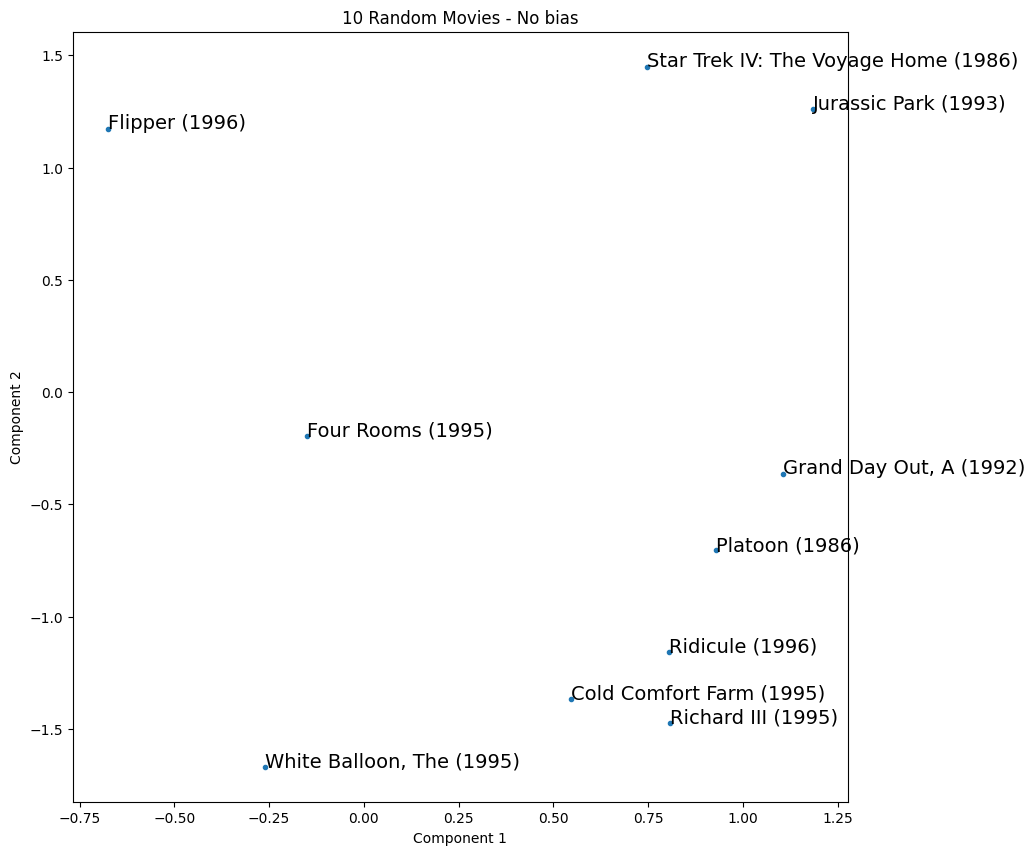

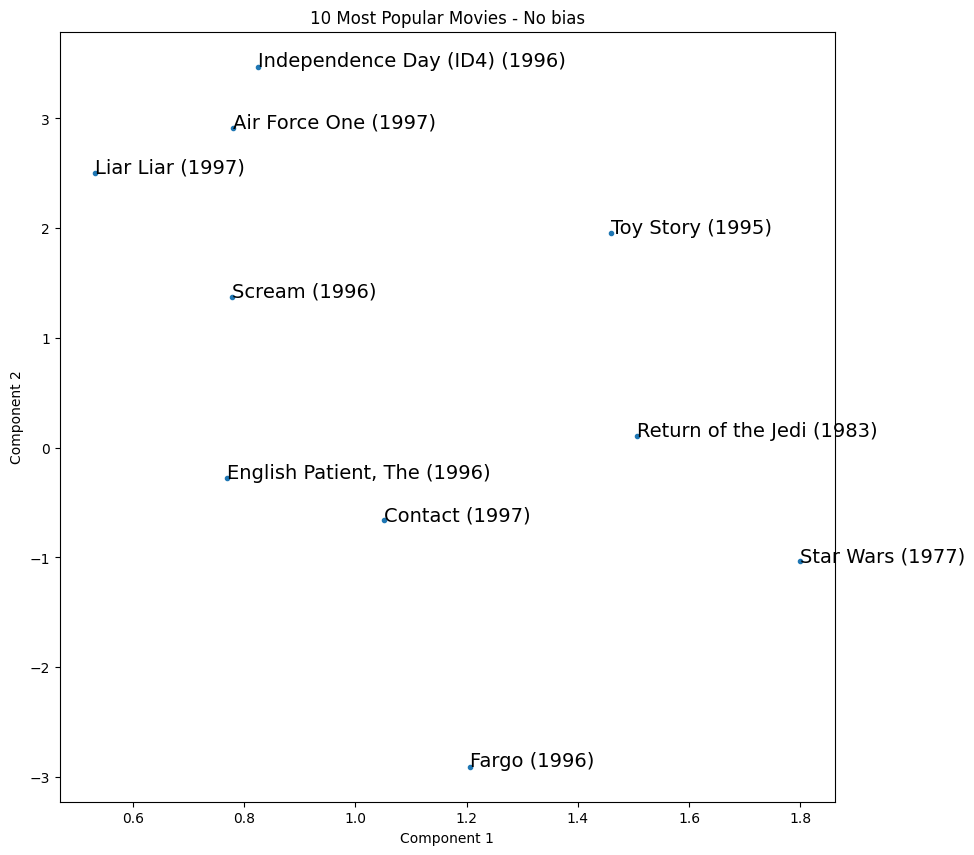

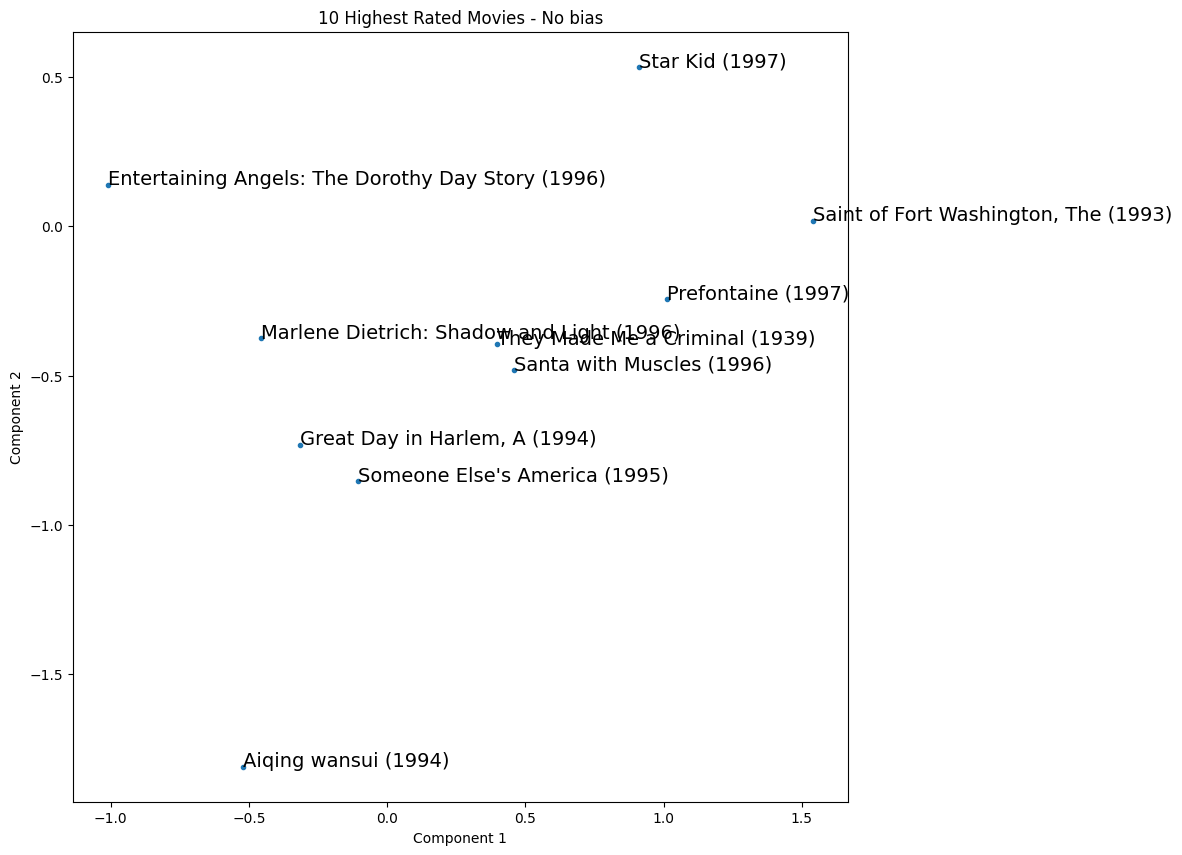

In [137]:
movie_names = np.array(movies)[:, 1]
movie_indicies = np.array([2, 9, 17, 81, 111, 115, 156, 188, 223, 229])
movie_coords = V_tilde[:, movie_indicies]
movie_labels = movie_names[movie_indicies]

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(movie_coords[0], movie_coords[1], '.')
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title("10 Random Movies - No bias")
for idx, label in enumerate(movie_labels):
    ax.annotate(label, (movie_coords[0, idx], movie_coords[1, idx]), fontsize=14)
plt.savefig("nobias_rand10_viz.png", dpi=600, bbox_inches="tight")

print(movie_indicies)
print(top10popularmovies_indices)
movie_coords = V_tilde[:, top10popularmovies_indices]
movie_labels = movie_names[top10popularmovies_indices]
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(movie_coords[0], movie_coords[1], '.')
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title("10 Most Popular Movies - No bias")
for idx, label in enumerate(movie_labels):
    ax.annotate(label, (movie_coords[0, idx], movie_coords[1, idx]), fontsize=14)
plt.savefig("nobias_pop10_viz.png", dpi=600, bbox_inches="tight")

movie_coords = V_tilde[:, top10ratedmovies_indices]
movie_labels = movie_names[top10ratedmovies_indices]
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(movie_coords[0], movie_coords[1], '.')
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title("10 Highest Rated Movies - No bias")
for idx, label in enumerate(movie_labels):
    ax.annotate(label, (movie_coords[0, idx], movie_coords[1, idx]), fontsize=14)
plt.savefig("nobias_high10_viz.png", dpi=600, bbox_inches="tight")

### Homework 5 + bias: Implementation

In [110]:
def grad_U_bias(Ui, Yij, Vj, ai, bj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * (reg * Ui - Vj * (Yij - np.matmul(Vj, Ui) - ai - bj))

def grad_V_bias(Vj, Yij, Ui, ai, bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * (reg * Vj - Ui * (Yij - np.matmul(Vj, Ui) - ai - bj))

def grad_bias(Vj, Yij, Ui, ai, bj, eta):
    return -1 * eta * (Yij - np.dot(Ui, Vj) - ai - bj)

def get_err_bias(U, V, Y, a, b, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    errors = []
    for i, j, Y_ij in Y:
        errors.append(0.5 * (Y_ij - np.matmul(V[j-1], U[i-1]) - a[i - 1] - b[j - 1])**2)
    return np.mean(errors)


def train_model_bias(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # Initialize entries of U and V and losses
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    a = np.random.uniform(-0.5, 0.5, (M, ))
    b = np.random.uniform(-0.5, 0.5, (N, ))
    loss_vals = [get_err(U, V, Y)]

    for iter in range(max_epochs):
      # Shuffle matrix
      Y = Y[np.random.permutation(len(Y))]
      for datum in Y:
        U[datum[0] - 1] -= grad_U_bias(U[datum[0] - 1], datum[2], V[datum[1] - 1], a[datum[0] - 1], b[datum[1] - 1], reg, eta)
        V[datum[1] - 1] -= grad_V_bias(V[datum[1] - 1], datum[2], U[datum[0] - 1], a[datum[0] - 1], b[datum[1] - 1], reg, eta)
        bias_grad = grad_bias(U[datum[0] - 1], datum[2], V[datum[1] - 1], a[datum[0] - 1], b[datum[1] - 1], eta)
        a[datum[0] - 1] -= bias_grad
        b[datum[1] - 1] -= bias_grad
      loss_vals.append(get_err(U, V, Y))
      if iter > 0 and (loss_vals[iter] - loss_vals[iter + 1]) / (loss_vals[0] - loss_vals[1]) <= eps:
        break
    return U, V, a, b, get_err(U, V, Y)

In [111]:
Y_train = np.array(train).astype(int)
Y_test = np.array(test).astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

reg = 0.0
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
U_bias,V_bias, A, B, err = train_model_bias(M, N, K, eta, reg, Y_train)
E_in = err
E_out = get_err(U, V, Y_test)
print(f"E_in: {E_in}")
print(f"E_out: {E_out}")

Factorizing with  943  users,  1682  movies.
E_in: 6.230776543133683
E_out: 0.6775757631616117


In [112]:
A_bias = np.linalg.svd(V_bias.transpose())[0]
V_tilde_bias = np.dot(A_bias[:,:2].transpose(), V_bias.transpose())
U_tilde_bias = np.dot(A_bias[:,:2].transpose(), U_bias.transpose())

for i in range(len(V_tilde)):
    V_tilde_bias[i] -= np.mean(V_tilde_bias[i])
    V_tilde_bias[i] /= np.std(V_tilde_bias[i])
    U_tilde_bias[i] -= np.mean(U_tilde_bias[i])
    U_tilde_bias[i] /= np.std(U_tilde_bias[i])

### Homework 5 + bias: Visualizations

['Four Rooms (1995)' 'Richard III (1995)' 'White Balloon, The (1995)'
 'Jurassic Park (1993)' 'Flipper (1996)' 'Cold Comfort Farm (1995)'
 'Platoon (1986)' 'Grand Day Out, A (1992)' 'Ridicule (1996)'
 'Star Trek IV: The Voyage Home (1986)']


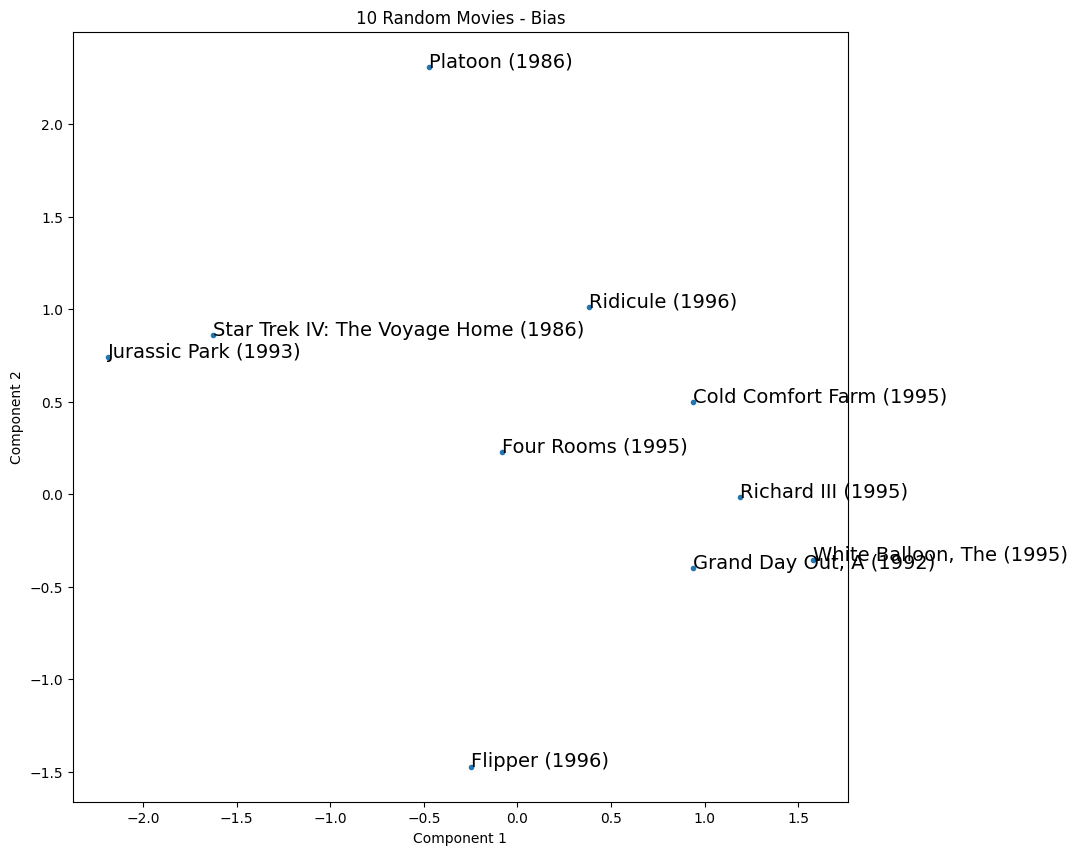

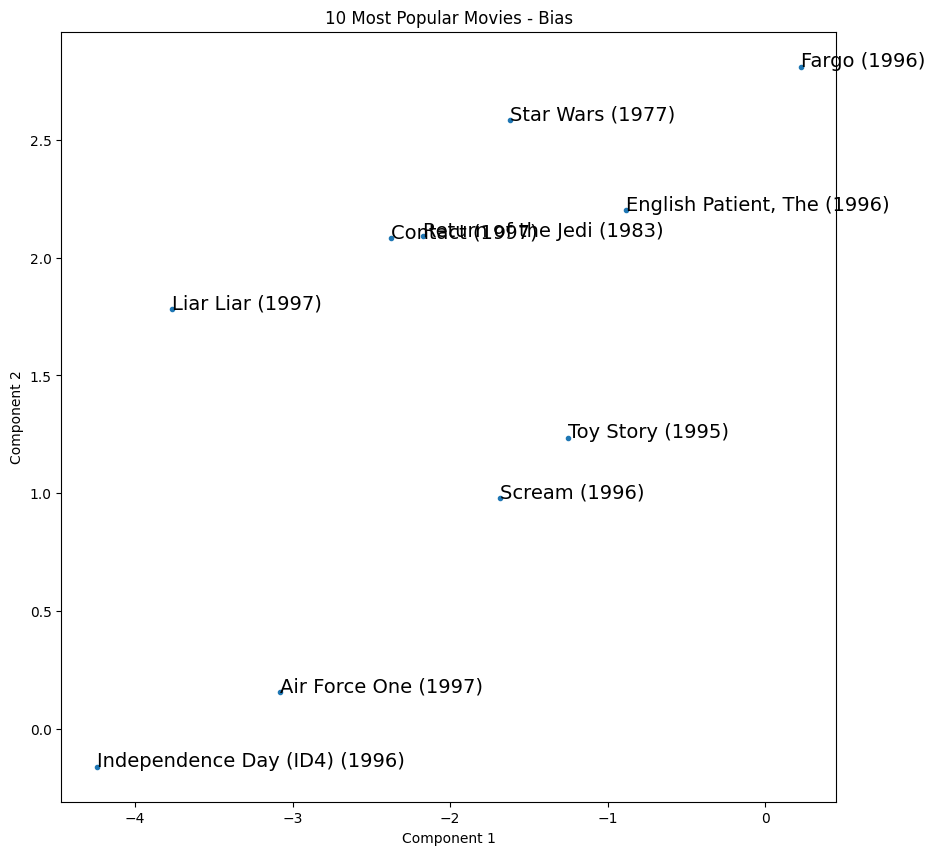

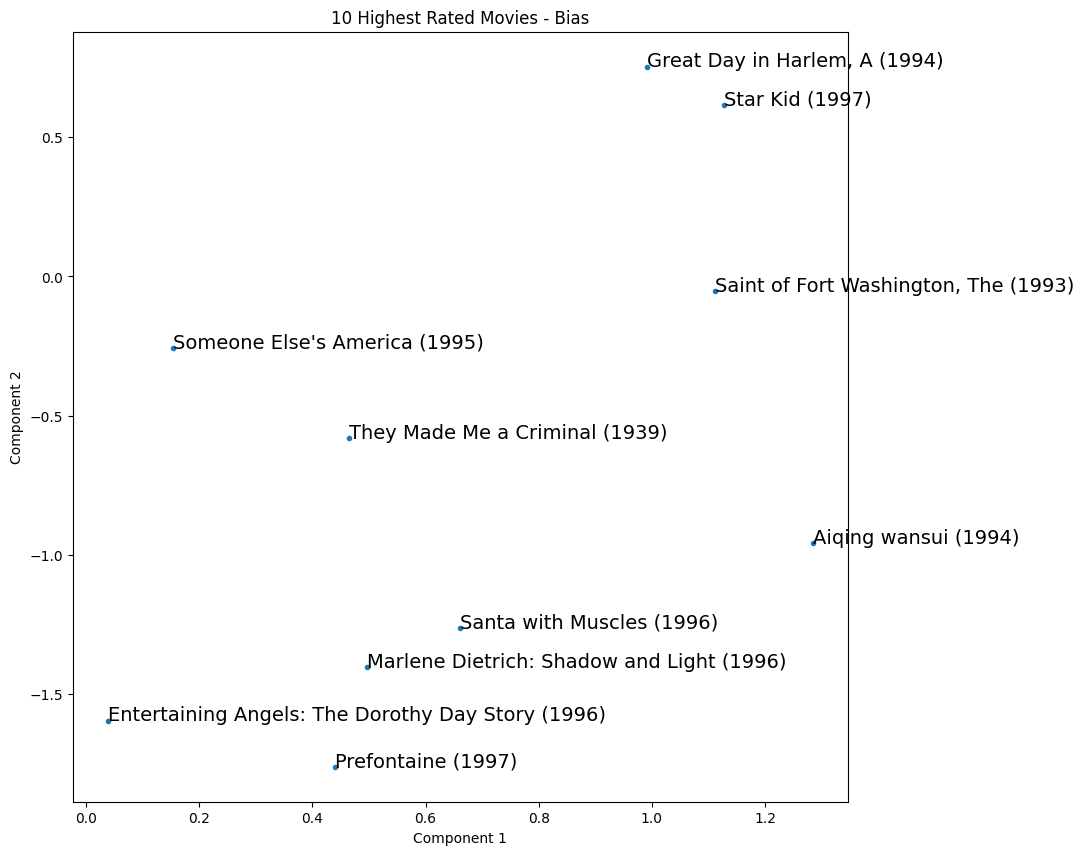

In [138]:
movie_names = np.array(movies)[:, 1]
movie_indicies = np.array([2, 9, 17, 81, 111, 115, 156, 188, 223, 229])
movie_coords = V_tilde_bias[:, movie_indicies]
movie_labels = movie_names[movie_indicies]
print(movie_labels)

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(movie_coords[0], movie_coords[1], '.')
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title("10 Random Movies - Bias")
for idx, label in enumerate(movie_labels):
    ax.annotate(label, (movie_coords[0, idx], movie_coords[1, idx]), fontsize=14)
plt.savefig("bias_rand10_viz.png", dpi=600, bbox_inches="tight")

movie_coords = V_tilde_bias[:, top10popularmovies_indices]
movie_labels = movie_names[top10popularmovies_indices]
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(movie_coords[0], movie_coords[1], '.')
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title("10 Most Popular Movies - Bias")
for idx, label in enumerate(movie_labels):
    ax.annotate(label, (movie_coords[0, idx], movie_coords[1, idx]), fontsize=14)
plt.savefig("bias_pop10_viz.png", dpi=600, bbox_inches="tight")

movie_coords = V_tilde_bias[:, top10ratedmovies_indices]
movie_labels = movie_names[top10ratedmovies_indices]
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(movie_coords[0], movie_coords[1], '.')
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title("10 Highest Rated Movies - Bias")
for idx, label in enumerate(movie_labels):
    ax.annotate(label, (movie_coords[0, idx], movie_coords[1, idx]), fontsize=14)
plt.savefig("bias_high10_viz.png", dpi=600, bbox_inches="tight")

### Off the Shelf: Implementation

Model training

In [24]:
# Initialize supriselib objects
reader = Reader(rating_scale=(1, 5))
sp_train = Dataset.load_from_df(df=train, reader=reader)
sp_test = Dataset.load_from_df(df=test, reader=reader)

sp_train = sp_train.build_full_trainset()
sp_test = sp_test.build_full_trainset()
sp_trainset = sp_train.build_testset()
sp_testset = sp_test.build_testset()

# Initialize SVD and fit
k_factors = 20
algo = SVD(n_factors = k_factors, n_epochs = 20, biased = True, lr_all = 0.005, reg_all = 0, init_mean = 0, init_std_dev = 0.01)
algo.fit(sp_train)

U = algo.pu
Vt = algo.qi.T

# Test fit
print(f'train: {accuracy.rmse(algo.test(sp_trainset), verbose = False)}')
print(f'test: {accuracy.rmse(algo.test(sp_testset), verbose = False)}')

train: 0.9115761138198302
test: 0.9364034738005771


In [25]:
len(movies)

1682

### Off the Shelf: Visualizations

In [41]:
movie_names = movies.iloc[:, 1]

In [45]:
def plot_2D(indicies, title, dirs):
    coords = Vt[:, indicies]
    labels = movie_names[indicies]
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    ax.scatter(coords[0], coords[1])
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_title(title)
    for idx, label in enumerate(labels):
        ax.annotate(label, (coords[0, idx], coords[1, idx]), fontsize = 10)
    plt.savefig(dirs, dpi = 600, bbox_inches = "tight")
    return fig

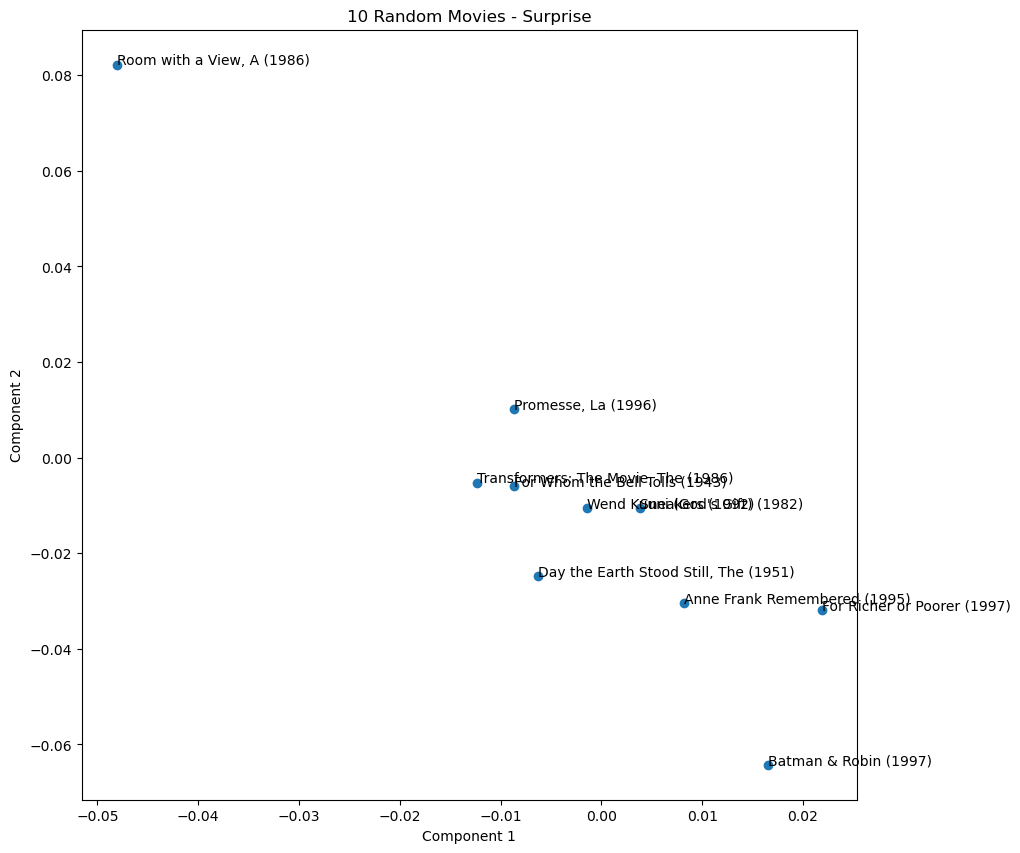

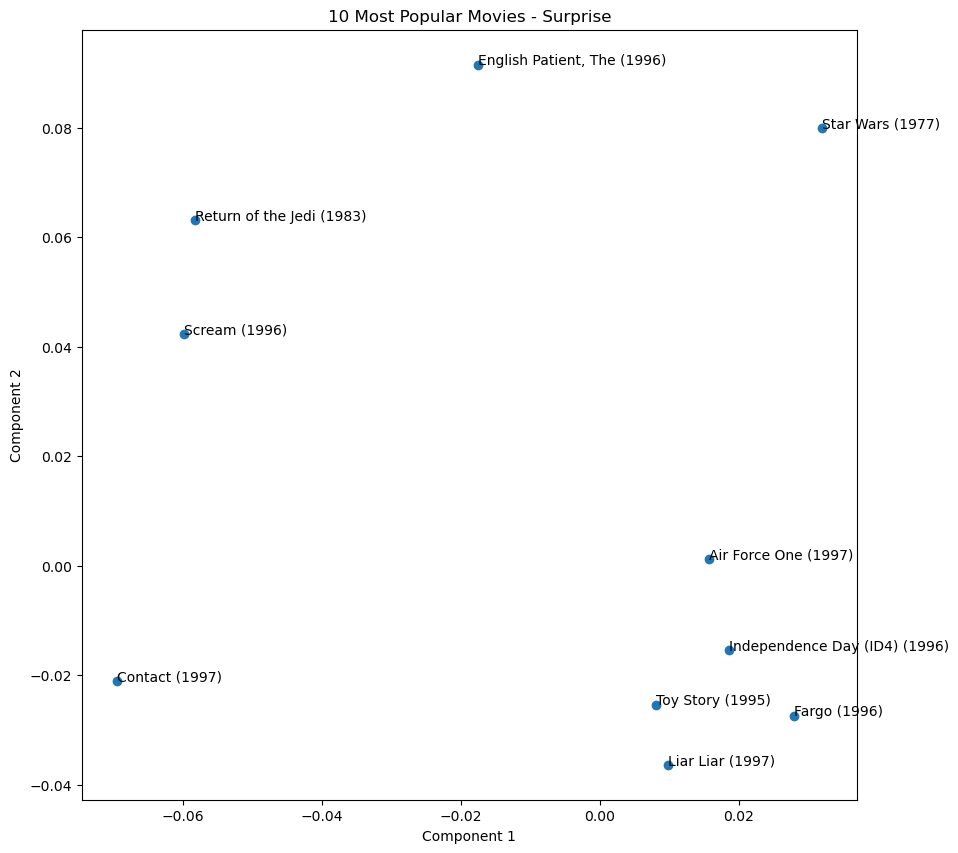

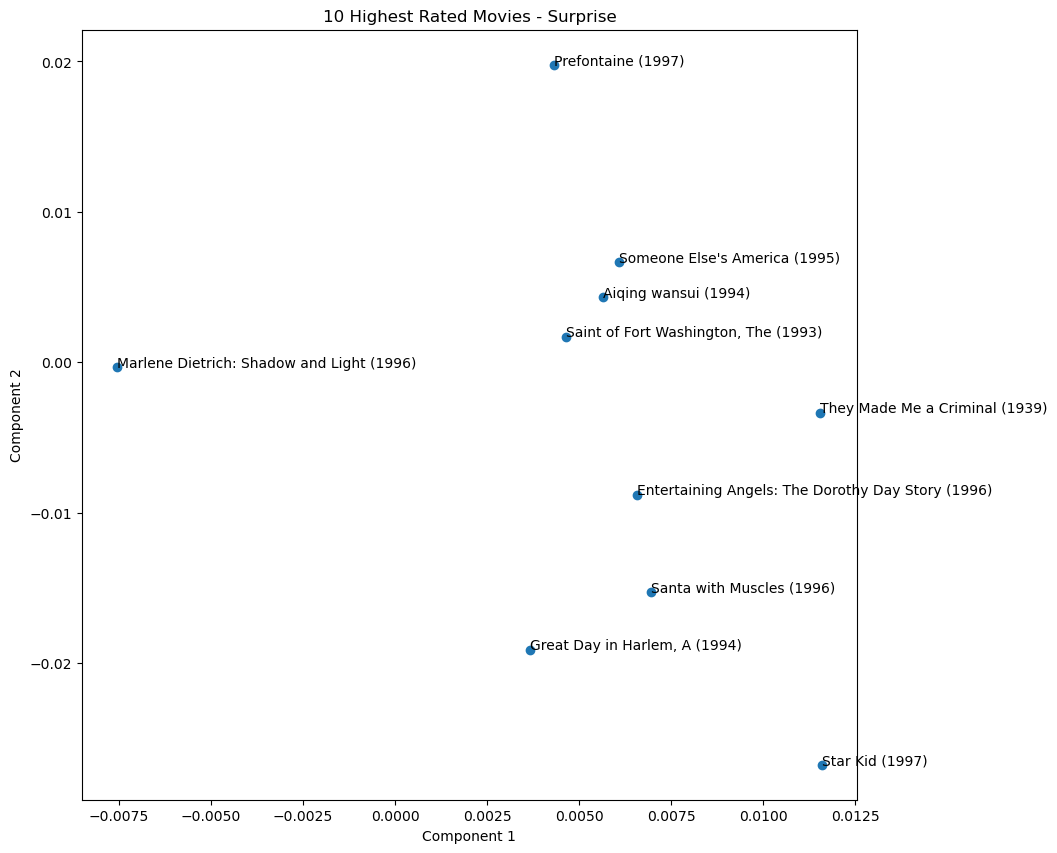

In [46]:
# random 10 movies
rand_indicies = np.random.randint(0, len(movies), size = (num_plot))
title = "10 Random Movies - Surprise"
dirs = "svd_rand10_viz.png"
fig_rand = plot_2D(rand_indicies, title, dirs)

# top10 high rating
title = "10 Most Popular Movies - Surprise"
dirs = "svd_pop10_viz.png"
fig2_top = plot_2D(top10popularmovies_indices, title, dirs)

# top10, received most ratings
title = "10 Highest Rated Movies - Surprise"
dirs = "svd_most10_viz.png"
fig_most = plot_2D(top10ratedmovies_indices, title, dirs)